## Import

In [1]:
# notebooky stuff
%load_ext autoreload
%autoreload 2
from IPython.display import display

import sys 
sys.path.append('../../src/modules')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import eumf_data, eumf_eval, eumf_pipeline, eumf_custom_models
from sklearn import compose, pipeline, preprocessing, linear_model, model_selection, ensemble, feature_selection
import seaborn as sns


# pandas pretty output
pd.set_option('display.min_rows', 20)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

## Data

### Load all data

In [2]:
# migration rates
df_values = eumf_data.load_registrations_from_csv(impute_missing=True)

# google trends
df_trends = eumf_data.load_trends_from_csv()

countries = eumf_data.get_countries()
keyword_ids = df_trends.columns.levels[0].tolist()

df_gdp = eumf_data.read_gdp()
df_unempl = eumf_data.read_unempl()


### Join data, combine countries

In [3]:
country_combinations = [
    ["GR", "CY"],
    ["LV", "LT", "EE"],
    ["BE", "NL", "LU"],
    ["CZ", "SK"],
    ["SE", "FI", "DK"],
    ["AT", "CH"]
]

panel = df_values.join(df_trends, how="outer")
panel_3m = panel.resample("3M", closed="left").mean()

panel_comb = eumf_data.combine_countries(panel, combinations=country_combinations)
panel_comb_3m = eumf_data.combine_countries(panel_3m, combinations=country_combinations)
df_gdp_comb = eumf_data.combine_countries(df_gdp, combinations=country_combinations)
df_unempl_comb = eumf_data.combine_countries(
    df_unempl, combinations=country_combinations, average=True
)
# note: strictly, unweighted average is wrong for unemployment, but should work in most cases

panel_comb_3m_macro = panel_comb_3m.join(df_gdp_comb).join(df_unempl_comb)

panel_comb_3m_macro["2017":"2018"]


10                                                                                                                        11                                                                                                                                            112                                                                                                               ...   value                                                                                                                                     gdp                                                                                                                                                 unempl                                                                                                       
country     AT+CH  BE+NL+LU  BG  CZ+SK    ES      FR      GB   GR+CY  HR   HU   IE     IT   LV+LT+EE    PL    PT   RO  SE+FI+DK  SI   AT+CH  BE+NL+LU    BG    CZ+SK     ES      FR      GB    GR+CY    HR      HU      IE      IT   LV+LT+EE    PL      PT      RO   SE+FI+DK  SI   AT+CH  BE+NL+LU    BG    CZ+SK      ES      FR      GB    GR+CY     HR      HU      IE      IT   LV+LT+EE    PL    ...     ES        FR        GB      GR+CY       HR        HU       IE        IT     LV+LT+EE     PL        PT        RO     SE+FI+DK    SI     AT+CH   BE+NL+LU    BG    CZ+SK     ES      FR      GB    GR+CY      HR      HU      IE       IT   LV+LT+EE    PL      PT      RO   SE+FI+DK    SI   AT+CH  BE+NL+LU  BG  CZ+SK   ES   FR   GB  GR+CY    HR   HU   IE    IT  LV+LT+EE  PL   PT   RO  SE+FI+DK  SI 
date                                                                                                                                                                                                                                                                                                                                                                                                    ...                                                                                                                                                                                                                                                                                                                                                                                                              
2017-03-31  10.524  16.048   0.0   0.0  26.667  21.857  21.381   0.0  0.0  0.0  0.0  14.095    0.0     6.095  0.0  0.0  21.286   0.0  34.714  60.190    2.190  10.857  38.714  29.810  53.381  12.810  0.000   0.619  11.095  22.048    0.0    11.952  12.714  11.571  26.524   0.0  97.190  178.952  42.238  127.048  33.143  63.333  47.286  29.619  63.095  62.810  59.333  14.905  179.429  39.524  ...  1689.000  1268.333  1080.333  2399.000  4459.000  3747.667  156.000  5255.333  1396.333  12264.667  866.333  18186.333  654.333  420.333  28780.0  42970.0  1510.0  7620.0  5950.0  8450.0  9080.0   9270.0  2590.0  2820.0  14640.0  6800.0  10490.0  2760.0  4520.0  1850.0  33780.0  4790.0  2.85    6.433   6.6  6.00  18.2  9.6  4.6  17.35  12.7  4.3  7.4  11.6   7.333   5.3  9.8  5.3   7.167   7.4
2017-06-30   4.952  14.810   0.0   0.0  21.048  13.952  18.857   0.0  0.0  0.0  0.0  15.286    0.0     6.524  0.0  0.0  27.714   0.0  39.286  61.619   10.619   7.714  24.381  27.952  55.714   8.286  2.333   7.095  20.619  17.286    0.0    13.810  23.143  11.143  32.857   0.0  85.619  168.905  35.190   83.429  23.810  57.857  48.000  36.476  33.048  27.905  62.810  14.286  126.667  21.476  ...  1427.667  1023.333  1049.000  2163.000  4121.333  3637.667  164.667  4699.000  1407.000  12940.000  609.667  19264.000  520.333  365.000  29250.0  44540.0  1800.0  8470.0  6330.0  8560.0  8980.0  10000.0  2990.0  3200.0  14700.0  7140.0  11780.0  2960.0  4790.0  2200.0  35590.0  5260.0  2.70    5.867   6.2  5.75  17.3  9.6  4.4  16.70  11.5  4.3  6.7  11.3   7.667   5.1  9.2  4.9   7.133   6.6
2017-09-30   4.905  16.095   0.0   0.0  12.4

## Experiments

### Common definitions

In [4]:
T_MIN = "2010"
T_MAX = "2019"

T_TEST_MIN = "2014"
T_TEST_MAX = "2014"

cv_default = model_selection.KFold(n_splits=8, shuffle=False)
cv_random = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

### Random Forest - possible feature combinations

In [5]:
### TRAINING

feature_combinations = [
    ["dummy"],
    ["19"],
    ["gdp", "unempl"],
    ["19", "gdp", "unempl"],
    ["value"],
    ["value", "19"],
    ["value", "gdp", "unempl"],
    ["value", "19", "gdp", "unempl"],
]

tuners, estimators = [], []
cv_scores, test_scores = [], []
train_stackeds, test_stackeds, train_unstackeds = [], [], []

params = {
    "randomforestregressor__max_features": ["auto", "sqrt"],
    "randomforestregressor__min_samples_leaf": [1, 2, 4, 8],
    "randomforestregressor__min_samples_split": [2, 4, 8, 16],
}

for features in feature_combinations:

    if "dummy" in features:
        columns = ["value"]
        lags = [1]
    else:
        columns = features
        lags = [1, 2, 3, 4, 5, 6]

    labeled = eumf_pipeline.prepare_data(
        panel_comb_3m_macro, columns=columns, lags=lags, t_min=T_MIN, t_max=T_MAX,
    )
    transformed = eumf_pipeline.transform_data(labeled)
    train, test = eumf_pipeline.split_data(
        transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
    )
    train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)

    train_stackeds.append(train_stacked)
    train_unstackeds.append(train)
    test_stackeds.append(test_stacked)

    if "dummy" in features:
        tuner = None
        estimator = eumf_custom_models.make_linear_dummy_model(train_stacked)
    else:
        tuner = eumf_pipeline.train_reg_model(
            train_stacked,
            reg=ensemble.RandomForestRegressor(random_state=42),
            extra_pipeline_steps=[preprocessing.StandardScaler()],
            params=params,
            scoring=eumf_eval.scorer_rmse,
        )
        estimator = tuner.best_estimator_
    tuners.append(tuner)
    estimators.append(estimator)

    cv_score = eumf_eval.score_cv(estimator, train_stacked, cv=cv_default,)
    cv_scores.append(cv_score)

    test_score = eumf_eval.score_test(estimator, test_stacked,)
    test_scores.append(test_score)


In [6]:
pd.DataFrame(
    {
        str(k): t.best_params_
        for k, t in zip(feature_combinations, tuners)
        if t is not None
    }
).transpose()



,randomforestregressor__max_features,randomforestregressor__min_samples_leaf,randomforestregressor__min_samples_split
['19'],sqrt,2,2
"['gdp', 'unempl']",sqrt,8,2
"['19', 'gdp', 'unempl']",sqrt,2,2
['value'],auto,4,2
"['value', '19']",auto,4,2
"['value', 'gdp', 'unempl']",auto,4,2
"['value', '19', 'gdp', 'unempl']",auto,2,2


In [7]:
eumf_eval.agg_multiple_cv_scores(cv_scores, feature_combinations, use_quantiles=True)[
    ["test_rmse", "test_r2_mod", "test_mae", "test_explained_variance"]
].sort_values(("test_rmse", 0.5), ascending=False)


test_rmse               test_r2_mod               test_mae               test_explained_variance              
                                    0.25    0.50   0.75      0.25     0.50   0.75    0.25    0.50   0.75            0.25           0.50   0.75 
['value', '19']                    -0.120  -0.087 -0.077     0.347    0.478  0.658  -0.073  -0.064 -0.056           0.338          0.407  0.520
['value', 'gdp', 'unempl']         -0.116  -0.090 -0.077     0.369    0.420  0.647  -0.075  -0.066 -0.058           0.341          0.398  0.489
['value', '19', 'gdp', 'unempl']   -0.115  -0.090 -0.075     0.362    0.452  0.640  -0.074  -0.067 -0.056           0.335          0.394  0.465
['value']                          -0.122  -0.093 -0.078     0.327    0.415  0.652  -0.077  -0.066 -0.059           0.318          0.362  0.522
['dummy']                          -0.121  -0.097 -0.084     0.208    0.348  0.700  -0.076  -0.066 -0.060           0.169          0.251  0.583
['19', 'gdp', 'unempl']            -0.161  -0.101 -0.084     0.187    0.272  0.390  -0.111  -0.074 -0.062           0.111          0.169  0.226
['gdp', 'unempl']                  -0.182  -0.107 -0.096    -0.001    0.136  0.320  -0.129  -0.083 -0.073           0.019          0.149  0.163
['19']                             -0.165  -0.112 -0.092    -0.049    0.200  0.516  -0.102  -0.080 -0.064          -0.032          0.129  0.193

In [8]:
eumf_eval.agg_multiple_test_scores(test_scores, feature_combinations).sort_values("rmse", ascending=False)

,mae,rmse,explained_variance,r2_mod
['value'],-0.086,-0.130,0.678,0.712
"['value', 'gdp', 'unempl']",-0.084,-0.131,0.675,0.710
"['value', '19', 'gdp', 'unempl']",-0.081,-0.132,0.671,0.704
"['value', '19']",-0.085,-0.137,0.650,0.684
['dummy'],-0.090,-0.142,0.623,0.658
['19'],-0.108,-0.188,0.366,0.400
"['19', 'gdp', 'unempl']",-0.128,-0.201,0.230,0.312
"['gdp', 'unempl']",-0.148,-0.222,0.074,0.160


#### Performance by year (CV+test)

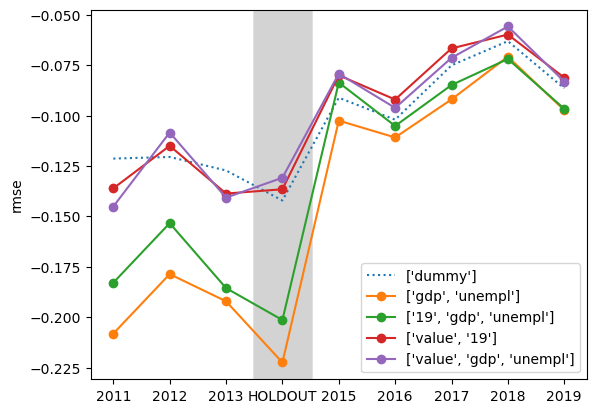

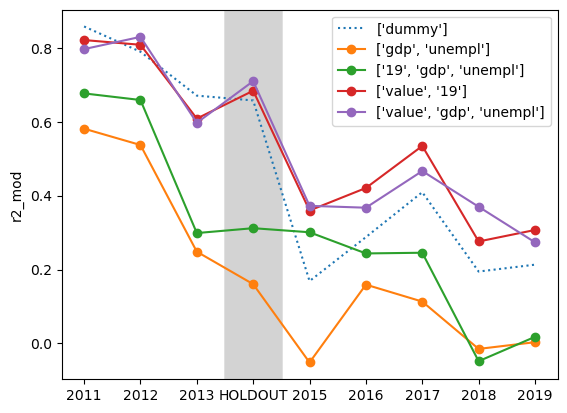

In [10]:
indices = [0, 2, 3, -3, -2]
metrics = ["rmse", "r2_mod"]

fold_labels = [2011, 2012, 2013, "HOLDOUT", 2015, 2016, 2017, 2018, 2019]

for m in metrics:
    eumf_eval.cv_performance_plot(
        cv_scores,
        m,
        indices=indices,
        run_labels=feature_combinations,
        fold_labels=fold_labels,
        test_scores=test_scores,
        test_pos=fold_labels.index("HOLDOUT"),
        benchmark_indices=[0]
    )
    plt.show()


#### Performance by country

##### prepare dummy scores

In [87]:
test_scores_c_dummy = eumf_eval.score_test_countries(estimators[0], test_stackeds[0])
cv_scores_c_dummy = eumf_eval.score_cv_countries(estimators[0], train_unstackeds[0], cv_default)

##### best model without AR lags: KW19 + econ

test scores

In [88]:
i = 3

test_scores_c = eumf_eval.score_test_countries(estimators[i], test_stackeds[i])
test_scores_c["rmse_vs_dummy"] = test_scores_c["rmse"] - test_scores_c_dummy["rmse"]
print("Holdout scores per country:")
display(test_scores_c.sort_values(by="r2_mod", ascending=False))

Holdout scores per country:


,mae,rmse,explained_variance,r2_mod,rmse_vs_dummy
IT,-0.053,-0.064,0.463,0.912,0.011
FR,-0.011,-0.018,0.425,0.853,0.013
CZ+SK,-0.043,-0.052,-0.301,0.629,0.014
HU,-0.051,-0.055,0.639,0.629,0.017
HR,-0.440,-0.598,0.042,0.466,-0.176
RO,-0.264,-0.275,0.209,0.427,-0.078
LV+LT+EE,-0.081,-0.085,-0.250,0.393,-0.055
BG,-0.220,-0.229,0.093,0.343,-0.025
SE+FI+DK,-0.044,-0.054,0.242,0.211,0.037
PL,-0.060,-0.065,0.100,0.081,0.025


CV scores

In [94]:
i = 3

cv_scores_c = eumf_eval.score_cv_countries(estimators[i], train_unstackeds[i], cv_default)
cv_scores_c["rmse_vs_dummy"] = cv_scores_c["rmse"] - cv_scores_c_dummy["rmse"]
print("CV scores per country:")
cv_scores_c_agg = eumf_eval.agg_cv_scores(cv_scores_c, level=0, use_quantiles=True)
display(cv_scores_c_agg.sort_values(by=("rmse", 0.5), ascending=False))


CV scores per country:


mae                  rmse                explained_variance               r2_mod                   rmse_vs_dummy                  
          0.25   0.50   0.75   0.25   0.50   0.75         0.25         0.50   0.75   0.25     0.50     0.75       0.25      0.50     0.75   
FR       -0.041 -0.031 -0.026 -0.054 -0.039 -0.031       -0.719       -0.004  0.253 -0.717 -2.848e-02  0.344     -0.014     0.005  1.235e-02
SE+FI+DK -0.049 -0.038 -0.028 -0.057 -0.044 -0.035       -0.388        0.133  0.221 -0.392  1.279e-01  0.262     -0.002     0.003  1.142e-02
AT+CH    -0.090 -0.044 -0.031 -0.108 -0.051 -0.039       -1.733       -0.182  0.041 -1.240 -2.785e-01  0.146     -0.032    -0.013 -4.777e-03
BE+NL+LU -0.058 -0.041 -0.032 -0.068 -0.052 -0.040       -0.570       -0.367 -0.143 -0.920  3.380e-04  0.227      0.004     0.011  1.534e-02
BG       -0.075 -0.050 -0.038 -0.079 -0.053 -0.041       -0.483        0.212  0.643 -0.618  2.687e-01  0.662     -0.021     0.008  2.017e-02
IT       -0.095 -0.047 -0.041 -0.105 -0.054 -0.048       -0.076        0.038  0.155  0.260  4.230e-01  0.571     -0.047    -0.004  1.112e-03
PL       -0.106 -0.052 -0.030 -0.121 -0.064 -0.040       -0.380       -0.064  0.629  0.234  5.186e-01  0.799     -0.016     0.001  1.421e-02
GB       -0.070 -0.048 -0.029 -0.078 -0.064 -0.039       -0.517       -0.091  0.019  0.087  2.620e-01  0.464     -0.025    -0.003  1.816e-02
CZ+SK    -0.104 -0.053 -0.038 -0.134 -0.067 -0.045       -0.054        0.134  0.272  0.173  4.108e-01  0.595     -0.006     0.002  2.033e-02
IE       -0.089 -0.064 -0.049 -0.095 -0.074 -0.054       -0.027        0.086  0.204 -0.397  7.442e-03  0.398     -0.007     0.021  3.535e-02
HU       -0.163 -0.074 -0.040 -0.196 -0.080 -0.056       -0.528       -0.128  0.058  0.293  5.119e-01  0.669     -0.081    -0.012  3.263e-03
RO       -0.097 -0.084 -0.058 -0.105 -0.090 -0.071       -0.373        0.112  0.392 -0.464  8.726e-02  0.645     -0.039    -0.014  1.360e-02
LV+LT+EE -0.119 -0.086 -0.050 -0.124 -0.094 -0.053       -0.433        0.347  0.517 -0.188  6.883e-02  0.320     -0.049    -0.032 -2.110e-03
PT       -0.104 -0.087 -0.058 -0.122 -0.095 -0.066       -0.397       -0.159  0.204  0.229  3.937e-01  0.736     -0.033     0.019  3.569e-02
ES       -0.108 -0.096 -0.059 -0.124 -0.115 -0.062       -0.203        0.102  0.229  0.339  6.418e-01  0.777     -0.034    -0.015 -7.764e-03
GR+CY    -0.264 -0.109 -0.062 -0.267 -0.121 -0.072       -0.867       -0.187 -0.021 -0.748  2.754e-02  0.519     -0.112    -0.028 -9.606e-05
SI       -0.217 -0.143 -0.087 -0.257 -0.162 -0.117       -0.528       -0.162 -0.037  0.056  2.277e-01  0.501     -0.073    -0.032  1.071e-03
HR       -0.196 -0.147 -0.087 -0.198 -0.178 -0.097       -0.420       -0.123  0.334 -0.176  3.229e-01  0.397     -0.157    -0.034  1.414e-02

plot RMSE absolute

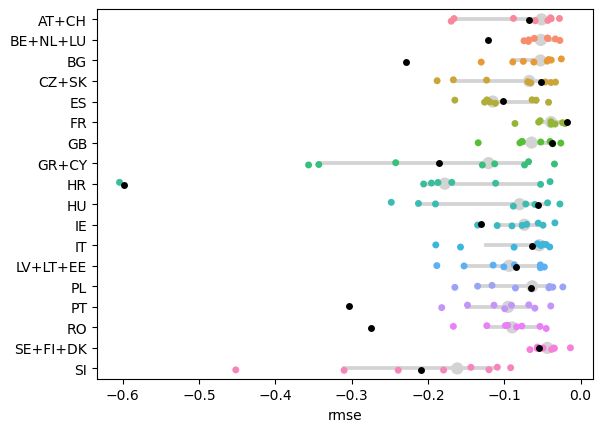

In [95]:
sns.pointplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="rmse",
    linestyles="",
    color="lightgrey",
    estimator=np.median
)
sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="rmse")
sns.stripplot(data=test_scores_c.reset_index(), y="index", x="rmse", color="k")
plt.ylabel("")
plt.show()


plot RMSE vs dummy

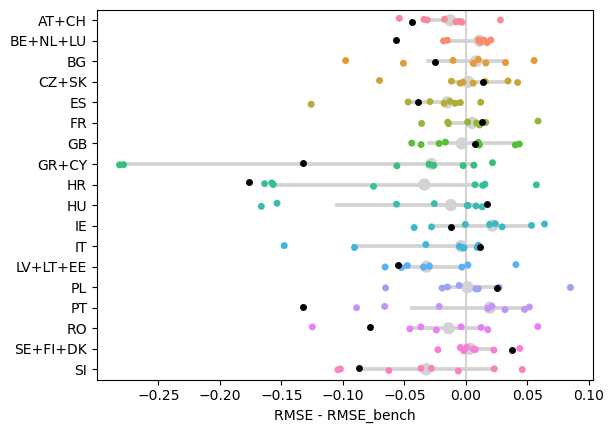

In [96]:
sns.pointplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="rmse_vs_dummy",
    linestyles="",
    color="lightgrey",
    estimator=np.median
)
sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="rmse_vs_dummy")
sns.stripplot(data=test_scores_c.reset_index(), y="index", x="rmse_vs_dummy", color="k")
plt.axvline(0.0, c="lightgrey")
plt.xlabel("RMSE - RMSE_bench")
plt.ylabel("")
plt.show()


plot R2

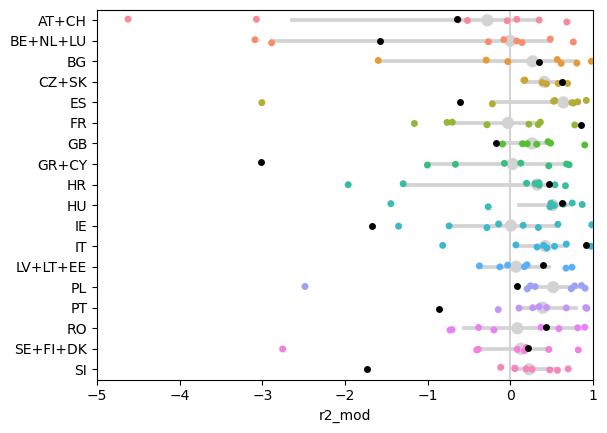

In [97]:
sns.pointplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="r2_mod",
    linestyles="",
    color="lightgrey",
    estimator=np.median,
)
sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="r2_mod")
sns.stripplot(data=test_scores_c.reset_index(), y="index", x="r2_mod", color="k")
plt.axvline(0.0, c="lightgrey")
plt.xlim(-5, 1)
plt.ylabel("")
plt.show()


##### best model with AR lags: value + KW19

test scores

In [99]:
i = -3

test_scores_c = eumf_eval.score_test_countries(estimators[i], test_stackeds[i])
test_scores_c["rmse_vs_dummy"] = test_scores_c["rmse"] - test_scores_c_dummy["rmse"]
print("Holdout scores per country:")
display(test_scores_c.sort_values(by="r2_mod", ascending=False))

Holdout scores per country:


,mae,rmse,explained_variance,r2_mod,rmse_vs_dummy
IT,-0.023,-0.025,0.842,0.986,4.976e-02
LV+LT+EE,-0.041,-0.048,-2.376,0.807,-1.809e-02
AT+CH,-0.020,-0.024,-0.141,0.792,-1.675e-04
HR,-0.345,-0.393,0.352,0.769,2.907e-02
FR,-0.021,-0.024,-0.280,0.742,7.278e-03
RO,-0.183,-0.223,-1.194,0.625,-2.544e-02
CZ+SK,-0.046,-0.053,-0.348,0.614,1.261e-02
PT,-0.118,-0.145,0.177,0.571,2.529e-02
GR+CY,-0.054,-0.064,-1.166,0.518,-1.166e-02
HU,-0.061,-0.065,0.586,0.495,8.243e-03


CV scores

In [100]:
i = -3

cv_scores_c = eumf_eval.score_cv_countries(estimators[i], train_unstackeds[i], cv_default)
cv_scores_c["rmse_vs_dummy"] = cv_scores_c["rmse"] - cv_scores_c_dummy["rmse"]
print("CV scores per country:")
cv_scores_c_agg = eumf_eval.agg_cv_scores(cv_scores_c, level=0, use_quantiles=True)
display(cv_scores_c_agg.sort_values(by=("rmse", 0.5), ascending=False))


CV scores per country:


mae                  rmse                explained_variance               r2_mod               rmse_vs_dummy                  
          0.25   0.50   0.75   0.25   0.50   0.75         0.25         0.50   0.75   0.25   0.50   0.75       0.25        0.50     0.75 
AT+CH    -0.049 -0.027 -0.023 -0.061 -0.035 -0.028       -1.104       -0.083  0.110  0.030  0.222  0.528   -4.026e-03  -1.065e-03  0.009
SE+FI+DK -0.041 -0.028 -0.023 -0.051 -0.040 -0.029       -0.954       -0.542  0.221 -0.926  0.040  0.465   -1.088e-06   3.969e-03  0.008
GB       -0.049 -0.029 -0.026 -0.057 -0.042 -0.030       -0.640       -0.316 -0.006  0.197  0.483  0.721    3.602e-03   5.877e-03  0.009
FR       -0.050 -0.032 -0.020 -0.062 -0.042 -0.025       -2.169       -0.828 -0.250 -0.267 -0.019  0.280   -2.217e-04   2.365e-03  0.012
BG       -0.063 -0.042 -0.035 -0.065 -0.045 -0.038       -4.499       -0.417  0.650 -0.314  0.148  0.522   -5.036e-03   1.001e-03  0.011
BE+NL+LU -0.047 -0.042 -0.027 -0.055 -0.046 -0.033       -0.649       -0.320 -0.129 -0.190  0.022  0.203    1.034e-02   1.220e-02  0.013
IT       -0.052 -0.046 -0.038 -0.057 -0.049 -0.046       -0.800       -0.140  0.334 -0.088  0.536  0.869   -6.428e-03  -7.448e-04  0.006
LV+LT+EE -0.062 -0.046 -0.033 -0.082 -0.056 -0.041       -1.321        0.006  0.341 -0.355  0.160  0.881   -1.347e-02  -8.861e-03  0.007
HU       -0.084 -0.054 -0.047 -0.091 -0.058 -0.056       -1.621       -0.724  0.268  0.571  0.735  0.808   -2.227e-02  -9.657e-03  0.003
ES       -0.070 -0.056 -0.032 -0.073 -0.059 -0.039       -0.136        0.299  0.666  0.582  0.800  0.919   -5.026e-03   3.527e-03  0.013
CZ+SK    -0.091 -0.045 -0.034 -0.109 -0.061 -0.044        0.257        0.424  0.513  0.373  0.531  0.614    2.784e-05   1.492e-02  0.031
RO       -0.078 -0.063 -0.055 -0.100 -0.074 -0.060       -1.452       -0.801 -0.677 -0.156  0.263  0.840   -1.523e-02  -9.711e-03  0.009
PL       -0.085 -0.065 -0.033 -0.108 -0.077 -0.036       -0.869        0.230  0.608  0.261  0.448  0.700   -5.760e-03   2.658e-03  0.014
IE       -0.088 -0.067 -0.042 -0.102 -0.081 -0.048       -1.292       -0.335 -0.121 -0.553  0.202  0.549    6.904e-03   1.788e-02  0.022
PT       -0.093 -0.085 -0.058 -0.104 -0.095 -0.068       -0.753       -0.430 -0.085  0.010  0.568  0.812    1.024e-02   1.338e-02  0.019
GR+CY    -0.115 -0.077 -0.061 -0.128 -0.102 -0.084       -0.419        0.069  0.229 -0.376 -0.152  0.644   -3.216e-02  -9.297e-03 -0.002
HR       -0.124 -0.071 -0.046 -0.149 -0.105 -0.058       -0.863       -0.068  0.334  0.548  0.591  0.622   -3.605e-02  -1.298e-03  0.021
SI       -0.140 -0.114 -0.078 -0.165 -0.132 -0.091       -0.570       -0.146  0.255  0.245  0.569  0.817   -5.485e-03   1.369e-02  0.026

plot RMSE absolute

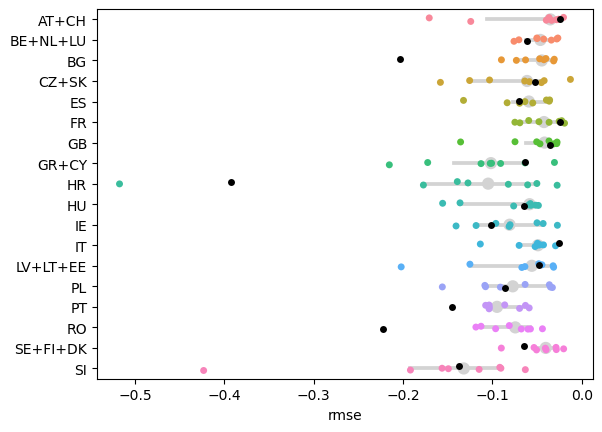

In [101]:
sns.pointplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="rmse",
    linestyles="",
    color="lightgrey",
    estimator=np.median
)
sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="rmse")
sns.stripplot(data=test_scores_c.reset_index(), y="index", x="rmse", color="k")
plt.ylabel("")
plt.show()


plot RMSE vs dummy

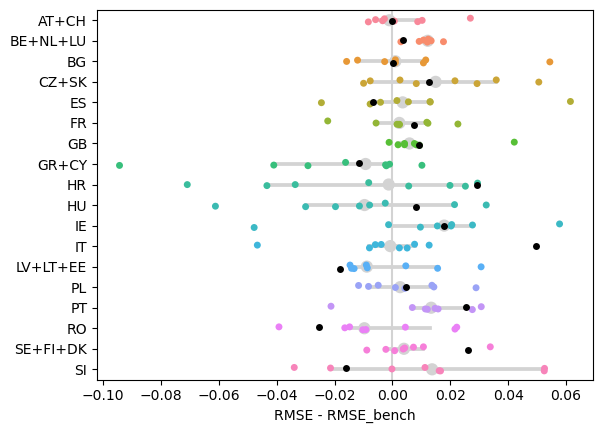

In [104]:
sns.pointplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="rmse_vs_dummy",
    linestyles="",
    color="lightgrey",
    estimator=np.median
)
sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="rmse_vs_dummy")
sns.stripplot(data=test_scores_c.reset_index(), y="index", x="rmse_vs_dummy", color="k")
plt.axvline(0.0, c="lightgrey")
plt.xlabel("RMSE - RMSE_bench")
plt.ylabel("")
plt.show()


plot R2

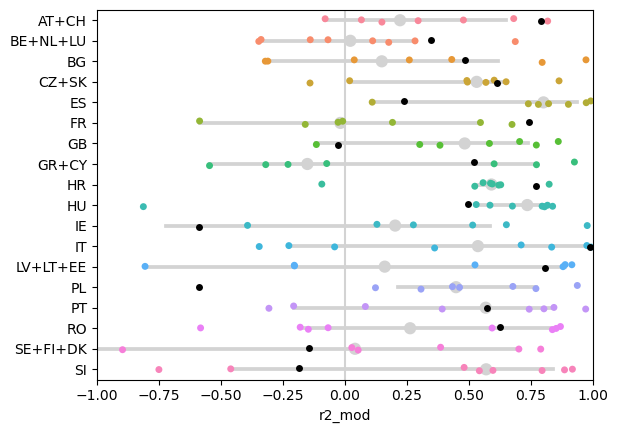

In [105]:
sns.pointplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="r2_mod",
    linestyles="",
    color="lightgrey",
    estimator=np.median,
)
sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="r2_mod")
sns.stripplot(data=test_scores_c.reset_index(), y="index", x="r2_mod", color="k")
plt.axvline(0.0, c="lightgrey")
plt.xlim(-1, 1)
plt.ylabel("")
plt.show()


#### How important is Google Trends for each country? (diff KW19 vs no KW19)


##### without own lags

In [106]:
i1, i2 = 3, 2
reg1, reg2 = tuners[i1].best_estimator_, tuners[i2].best_estimator_

cv_scores_c1 = eumf_eval.score_cv_countries(reg1, train_unstackeds[i1], cv_default)
cv_scores_c_agg1 = eumf_eval.agg_cv_scores(cv_scores_c1, level=0, use_quantiles=True)
cv_scores_c2 = eumf_eval.score_cv_countries(reg2, train_unstackeds[i2], cv_default)
cv_scores_c_agg2 = eumf_eval.agg_cv_scores(cv_scores_c2, level=0, use_quantiles=True)

cv_diff = cv_scores_c1 - cv_scores_c2
cv_diff_agg = eumf_eval.agg_cv_scores(cv_diff, level=0, use_quantiles=True)

cv_diff_agg["rmse"]

,0.25,0.50,0.75
AT+CH,-1.523e-03,1.790e-02,0.035
BE+NL+LU,4.551e-03,1.084e-02,0.043
BG,2.131e-03,4.827e-03,0.034
CZ+SK,-5.011e-03,1.629e-03,0.017
ES,2.966e-02,4.651e-02,0.056
FR,6.648e-04,5.106e-03,0.010
GB,-1.066e-02,1.711e-03,0.006
GR+CY,-1.190e-03,2.832e-02,0.032
HR,-1.969e-02,1.037e-04,0.005
HU,-1.429e-03,1.139e-03,0.005


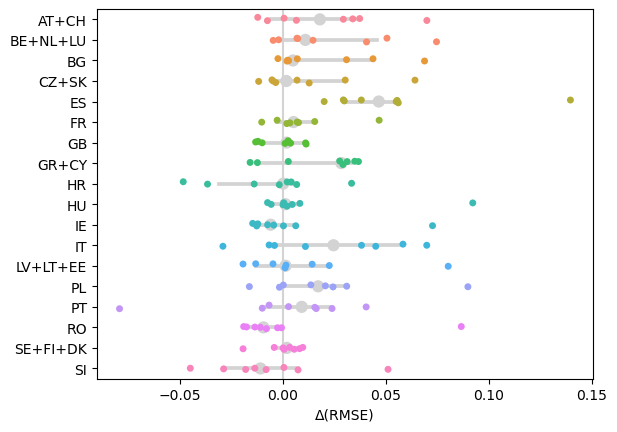

In [107]:
sns.pointplot(
    data=cv_diff.reset_index(),
    y="level_0",
    x="rmse",
    linestyles="",
    color="lightgrey",
    estimator=np.median,
)
sns.stripplot(data=cv_diff.reset_index(), y="level_0", x="rmse")
plt.axvline(0.0, c="lightgrey")
plt.ylabel("")
plt.xlabel("Δ(RMSE)")
plt.show()


##### with own lags

In [109]:
i1, i2 = 5, 4
reg1, reg2 = tuners[i1].best_estimator_, tuners[i2].best_estimator_

cv_scores_c1 = eumf_eval.score_cv_countries(reg1, train_unstackeds[i1], cv_default)
cv_scores_c_agg1 = eumf_eval.agg_cv_scores(cv_scores_c1, level=0, use_quantiles=True)
cv_scores_c2 = eumf_eval.score_cv_countries(reg2, train_unstackeds[i2], cv_default)
cv_scores_c_agg2 = eumf_eval.agg_cv_scores(cv_scores_c2, level=0, use_quantiles=True)

cv_diff = cv_scores_c1 - cv_scores_c2
cv_diff_agg = eumf_eval.agg_cv_scores(cv_diff, level=0, use_quantiles=True)

cv_diff_agg["rmse"]

,0.25,0.50,0.75
AT+CH,-5.078e-03,-5.978e-04,0.012
BE+NL+LU,1.140e-03,3.271e-03,0.007
BG,-7.079e-04,3.972e-03,0.013
CZ+SK,-3.182e-03,2.888e-03,0.019
ES,-2.754e-03,2.413e-03,0.013
FR,-2.719e-03,1.263e-03,0.002
GB,-2.832e-03,7.781e-03,0.012
GR+CY,-5.020e-03,-1.944e-03,0.002
HR,-6.014e-03,7.888e-03,0.017
HU,-8.353e-03,7.851e-04,0.008


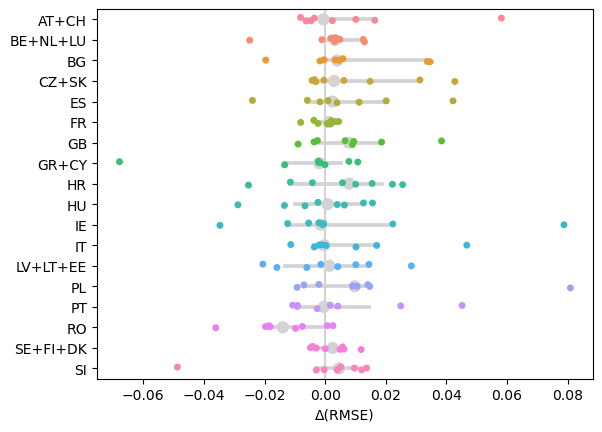

In [110]:
sns.pointplot(
    data=cv_diff.reset_index(),
    y="level_0",
    x="rmse",
    linestyles="",
    color="lightgrey",
    estimator=np.median,
)
sns.stripplot(data=cv_diff.reset_index(), y="level_0", x="rmse")
plt.axvline(0.0, c="lightgrey")
plt.ylabel("")
plt.xlabel("Δ(RMSE)")
plt.show()


#### feature importance

In [112]:
reg = tuners[3].best_estimator_
features_names_out = reg.steps[0][1].get_feature_names_out()
pd.Series(reg.steps[-1][1].feature_importances_, index=features_names_out).sort_values(
    ascending=False
)

19_1                1.650e-01
unempl_6            1.237e-01
19_2                8.105e-02
unempl_5            7.530e-02
unempl_4            6.244e-02
19_3                6.087e-02
unempl_3            5.991e-02
unempl_2            4.824e-02
unempl_1            4.253e-02
19_5                3.468e-02
19_6                3.446e-02
19_4                3.122e-02
gdp_1               2.986e-02
gdp_6               2.703e-02
gdp_3               2.317e-02
gdp_5               2.208e-02
gdp_2               2.142e-02
gdp_4               2.079e-02
country_SI          1.031e-02
country_HR          5.013e-03
country_GR+CY       3.884e-03
country_RO          3.312e-03
country_ES          2.700e-03
country_HU          2.597e-03
country_PT          1.100e-03
country_AT+CH       1.040e-03
country_PL          1.036e-03
country_CZ+SK       9.959e-04
country_GB          9.798e-04
country_IT          7.189e-04
country_LV+LT+EE    6.199e-04
country_IE          5.953e-04
country_BE+NL+LU    5.174e-04
country_BG

In [114]:
reg = tuners[5].best_estimator_
features_names_out = reg.steps[0][1].get_feature_names_out()
pd.Series(reg.steps[-1][1].feature_importances_, index=features_names_out).sort_values(
    ascending=False
)

value_1             7.684e-01
19_1                5.688e-02
value_2             4.242e-02
19_2                2.049e-02
19_4                1.698e-02
value_4             1.638e-02
value_3             1.551e-02
19_3                1.537e-02
19_6                1.222e-02
19_5                1.199e-02
value_6             9.941e-03
value_5             9.825e-03
country_SI          1.029e-03
country_ES          9.438e-04
country_GR+CY       4.049e-04
country_HU          2.496e-04
country_RO          2.201e-04
country_HR          1.706e-04
country_IE          1.595e-04
country_IT          9.295e-05
country_PT          7.955e-05
country_AT+CH       7.107e-05
country_GB          5.676e-05
country_PL          3.501e-05
country_FR          3.326e-05
country_CZ+SK       3.039e-05
country_BE+NL+LU    1.575e-05
country_SE+FI+DK    2.288e-06
country_BG          2.001e-06
country_LV+LT+EE    0.000e+00
dtype: float64

#### Plot prediction

##### with own lags

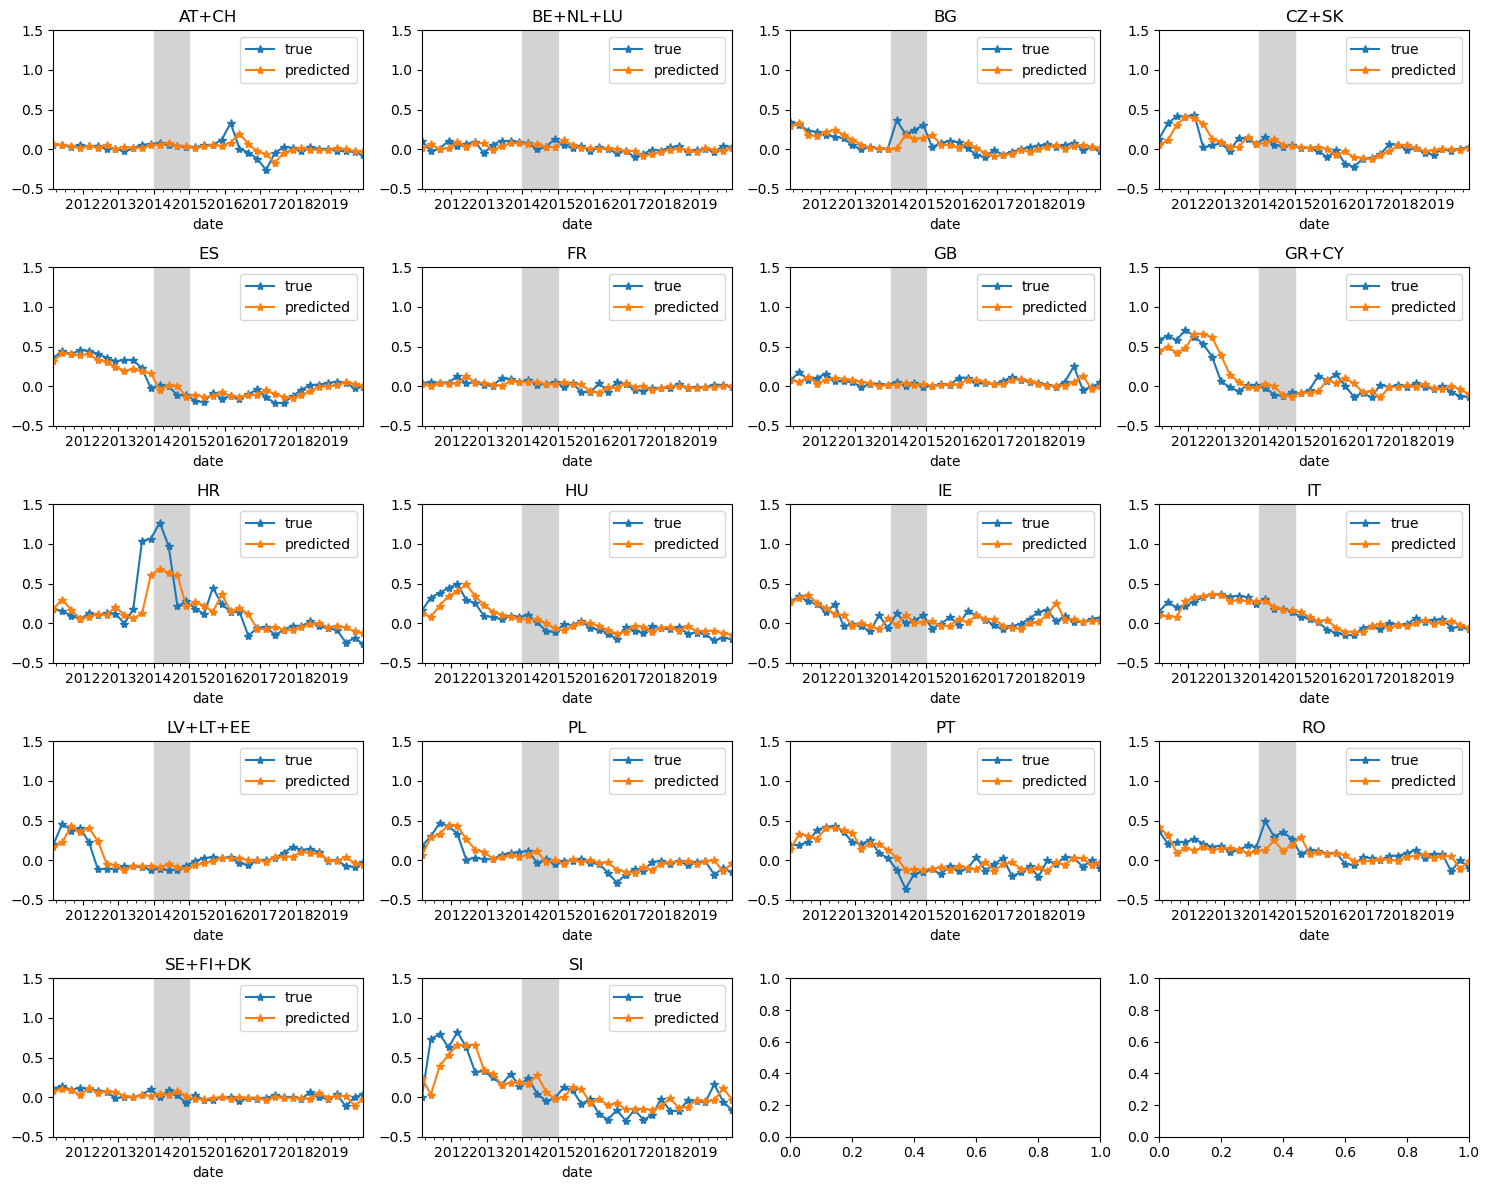

In [115]:
i = 5
reg = tuners[i].best_estimator_

y_pred_all = eumf_eval.predict_all(reg, train_stackeds[i], test_stackeds[i], cv_default)

fig, axs = eumf_eval.plot_prediction(
    y_pred_all,
    transformed.y,
    # eumf_pipeline.inv_transform_y(y_pred_all, labeled.y),
    # labeled.y,
    n_rows=5,
    n_cols=4,
    figsize=(15, 12),
    y_min=-0.5,
    y_max=1.5,
    marker="*",
    t_min="2011",
    vspan=("2014", "2015"),
    t_max="2019",
)
plt.show()


#### Without own lags

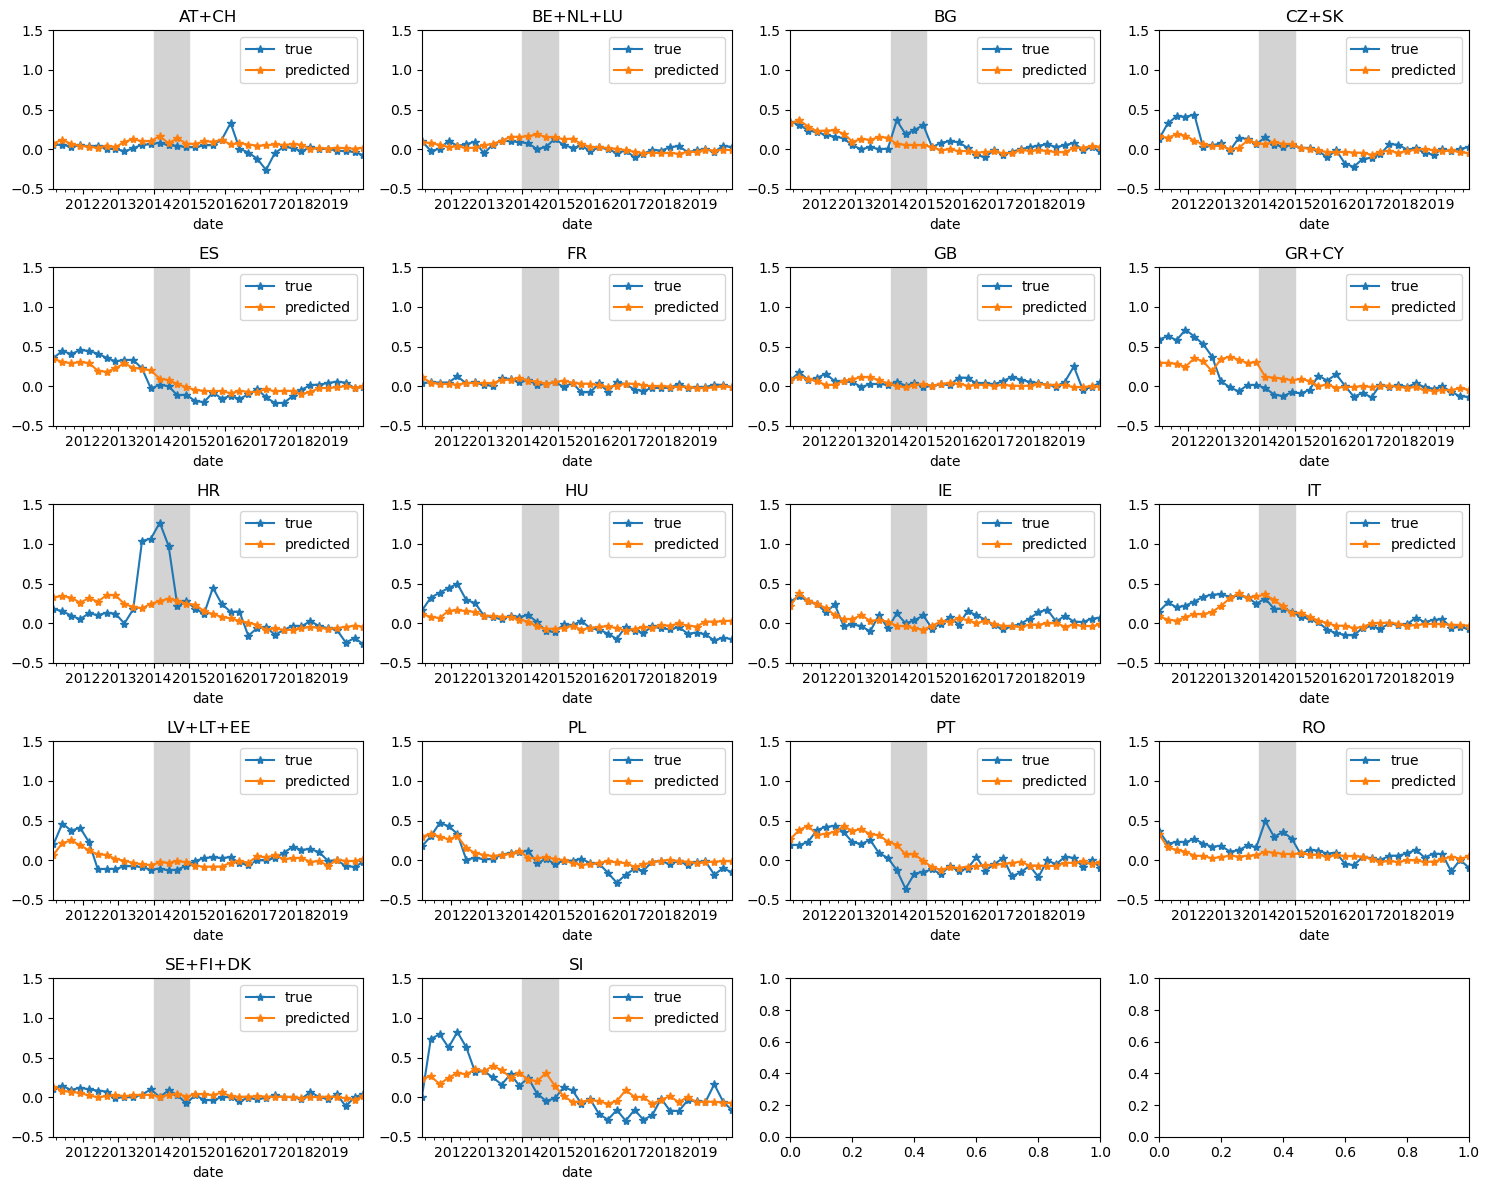

In [61]:
i = 2

reg = tuners[i].best_estimator_

y_pred_all = eumf_eval.predict_all(reg, train_stackeds[i], test_stackeds[i], cv_default)

fig, axs = eumf_eval.plot_prediction(
    y_pred_all,
    transformed.y,
    # eumf_pipeline.inv_transform_y(y_pred_all, labeled.y),
    # labeled.y,
    n_rows=5,
    n_cols=4,
    figsize=(15, 12),
    y_min=-0.5,
    y_max=1.5,
    marker="*",
    t_min="2011",
    vspan=("2014", "2015"),
    t_max="2019",
)
plt.show()

### monthly frequency with 3m rolling mean

In [64]:
### TRAINING

feature_combinations = [
    ["19"],
    ["value"],
    ["value", "19"],
]

tuners = []
cv_scores, test_scores = [], []
train_stackeds, test_stackeds = [], []

params = {
    "linearregression__fit_intercept": [True, False],
    "linearregression__positive": [True, False],
}

panel_resampled = panel_comb.rolling("90D").mean()

for features in feature_combinations:

    labeled = eumf_pipeline.prepare_data(
        panel_resampled, columns=features, lags=[3, 6, 9, 12, 15, 18]
    )
    transformed = eumf_pipeline.transform_data(labeled, delta=12)
    train, test = eumf_pipeline.split_data(
        transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
    )
    train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)
    train_stackeds.append(train_stacked)
    test_stackeds.append(test_stacked)

    tuner = eumf_pipeline.train_reg_model(
        train_stacked,
        reg=linear_model.LinearRegression(),
        extra_pipeline_steps=[preprocessing.StandardScaler()],
        dummy_encoder="drop",
        params=params,
        scoring=eumf_eval.scorer_rmse,
    )
    tuners.append(tuner)

    cv_score = eumf_eval.score_cv(tuner.best_estimator_, train_stacked, cv=cv_default,)
    cv_scores.append(cv_score)

    test_score = eumf_eval.score_test(tuner.best_estimator_, test_stacked,)
    test_scores.append(test_score)


In [66]:
eumf_eval.agg_multiple_cv_scores(cv_scores, feature_combinations, use_quantiles=True)


fit_time               score_time               test_mae               test_rmse               test_explained_variance               test_r2_mod              
                  0.25    0.50   0.75     0.25     0.50   0.75    0.25    0.50   0.75     0.25    0.50   0.75            0.25           0.50   0.75      0.25     0.50   0.75 
['19']            0.002   0.002  0.003    0.002    0.002  0.003  -0.113  -0.081 -0.076   -0.156  -0.132 -0.099          -0.018          0.072  0.252     0.023    0.368  0.430
['value']         0.002   0.002  0.002    0.002    0.002  0.002  -0.084  -0.071 -0.057   -0.131  -0.107 -0.076           0.305          0.386  0.539     0.299    0.476  0.623
['value', '19']   0.004   0.005  0.007    0.004    0.004  0.006  -0.085  -0.069 -0.056   -0.119  -0.103 -0.075           0.374          0.471  0.553     0.416    0.579  0.699

In [43]:
eumf_eval.agg_multiple_test_scores(test_scores, feature_combinations)

,mae,rmse,explained_variance,r2_mod
['19'],-0.115,-0.200,0.283,0.336
['value'],-0.075,-0.115,0.756,0.782
"['value', '19']",-0.075,-0.113,0.760,0.788


### More Keywords

#### best extra keyword

In [44]:
### TRAINING

feature_combinations = [
    ["19"],
    ["gdp", "unempl"],
    ["19", "gdp", "unempl"],
    ["value"],
    ["value", "19"],
    ["value", "gdp", "unempl"],
    ["value", "19", "gdp", "unempl"],
]

tuners = []
cv_scores, test_scores = [], []
train_stackeds, test_stackeds, train_unstackeds = [], [], []

# params = {}
params = {
    "randomforestregressor__max_features": ["auto", "sqrt"],
    "randomforestregressor__min_samples_leaf": [1, 2, 4, 8],
    "randomforestregressor__min_samples_split": [2, 4, 8, 16]
}

for features in feature_combinations:

    labeled = eumf_pipeline.prepare_data(
        panel_comb_3m_macro, columns=features, lags=[1, 2, 3, 4, 5, 6]
    )
    transformed = eumf_pipeline.transform_data(labeled)
    train, test = eumf_pipeline.split_data(
        transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
    )
    train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)

    train_stackeds.append(train_stacked)
    train_unstackeds.append(train)
    test_stackeds.append(test_stacked)

    tuner = eumf_pipeline.train_reg_model(
        train_stacked,
        reg=ensemble.RandomForestRegressor(random_state=42),
        extra_pipeline_steps=[preprocessing.StandardScaler()],
        params=params,
        scoring=eumf_eval.scorer_rmse,
    )
    tuners.append(tuner)

    cv_score = eumf_eval.score_cv(tuner.best_estimator_, train_stacked, cv=cv_default,)
    cv_scores.append(cv_score)

    test_score = eumf_eval.score_test(tuner.best_estimator_, test_stacked,)
    test_scores.append(test_score)


KeyboardInterrupt: 

#### feature elimination

In [45]:
columns = [
    c for c in panel_comb_3m_macro.columns.get_level_values(0).unique() if c != "value"
]

params = {
    "rfe__n_features_to_select": [8, 12, 16],
    "rfe__estimator__min_samples_leaf": [2, 4, 8],
}

labeled = eumf_pipeline.prepare_data(
    panel_comb_3m_macro, columns=columns, lags=[1, 2, 3, 4, 5, 6]
)
transformed = eumf_pipeline.transform_data(labeled)
train, test = eumf_pipeline.split_data(
    transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
)
train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)

reg = feature_selection.RFE(
    ensemble.RandomForestRegressor(random_state=42, min_samples_leaf=8), step=0.25
)

tuner = eumf_pipeline.train_reg_model(
    train_stacked,
    reg=reg,
    extra_pipeline_steps=[preprocessing.StandardScaler()],
    params=params,
    scoring=eumf_eval.scorer_rmse,
)

cv_score = eumf_eval.score_cv(tuner.best_estimator_, train_stacked, cv=cv_default,)

test_score = eumf_eval.score_test(tuner.best_estimator_, test_stacked)


In [35]:
pd.DataFrame(tuner.cv_results_).sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfe__estimator__min_samples_leaf,param_rfe__n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
7,12.562,0.459,0.028,0.001,8,12,"{'rfe__estimator__min_samples_leaf': 8, 'rfe__...",-0.163,-0.151,-0.100,-0.113,-0.087,-0.097,-0.118,0.029,1
6,12.565,0.476,0.026,0.002,8,8,"{'rfe__estimator__min_samples_leaf': 8, 'rfe__...",-0.161,-0.151,-0.101,-0.121,-0.087,-0.094,-0.119,0.028,2
8,10.181,0.542,0.017,0.004,8,16,"{'rfe__estimator__min_samples_leaf': 8, 'rfe__...",-0.166,-0.153,-0.102,-0.115,-0.084,-0.097,-0.119,0.030,3
5,15.732,0.612,0.029,0.001,4,16,"{'rfe__estimator__min_samples_leaf': 4, 'rfe__...",-0.165,-0.161,-0.102,-0.117,-0.084,-0.098,-0.121,0.031,4
4,15.511,0.684,0.029,0.002,4,12,"{'rfe__estimator__min_samples_leaf': 4, 'rfe__...",-0.164,-0.162,-0.102,-0.114,-0.087,-0.099,-0.121,0.031,5
2,19.242,0.626,0.028,0.001,2,16,"{'rfe__estimator__min_samples_leaf': 2, 'rfe__...",-0.159,-0.164,-0.102,-0.121,-0.087,-0.100,-0.122,0.030,6
1,19.617,1.124,0.033,0.008,2,12,"{'rfe__estimator__min_samples_leaf': 2, 'rfe__...",-0.164,-0.164,-0.100,-0.125,-0.084,-0.096,-0.122,0.032,7
3,16.137,0.642,0.028,0.003,4,8,"{'rfe__estimator__min_samples_leaf': 4, 'rfe__...",-0.159,-0.163,-0.101,-0.125,-0.090,-0.096,-0.122,0.029,8
0,19.224,0.514,0.032,0.003,2,8,"{'rfe__estimator__min_samples_leaf': 2, 'rfe__...",-0.168,-0.169,-0.103,-0.129,-0.091,-0.097,-0.126,0.032,9


In [36]:
tuner.best_params_

{'rfe__estimator__min_samples_leaf': 8, 'rfe__n_features_to_select': 12}

In [37]:
eumf_eval.agg_cv_scores(cv_score)

,mean,std,sem
fit_time,5.249,0.274,1.036e-01
score_time,0.013,0.001,3.887e-04
test_mae,-0.084,0.024,9.060e-03
test_rmse,-0.120,0.037,1.399e-02
test_explained_variance,0.001,0.281,1.062e-01
test_r2_mod,0.084,0.370,1.397e-01


In [38]:
test_score

mae                  -0.114
rmse                 -0.189
explained_variance    0.346
r2_mod                0.393
dtype: float64

##### non-zero coefficients

In [39]:
reg = tuner.best_estimator_
features_names_out = reg.steps[0][1].get_feature_names_out()
coefs = pd.Series(reg.steps[-1][1].support_, index=features_names_out).sort_values(
    ascending=False
)
coefs[coefs > 0.0]



unempl_4    True
19_4        True
55_3        True
117_1       True
119_1       True
19_1        True
19_3        True
19_2        True
unempl_1    True
unempl_3    True
unempl_2    True
gdp_2       True
dtype: bool